In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import diffrax as dfx
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
from jaxtyping import Array, PyTree
from typing import Callable
import matplotlib.pyplot as plt
import jax


In [3]:
#
# Define the new stateful operations.
#

_sentinel = object()

# Wraps another control to provide it with an additional argument `y`, which
# is a function `t -> y(t)` for the solution of the differential equation.
class SolutionDependentControl(dfx.AbstractPath):
    control: dfx.AbstractPath
    y: Callable[[float], PyTree[Array]] = _sentinel

    @property
    def t0(self):
        return self.control.t0

    @property
    def t1(self):
        return self.contr0l.t1

    def evaluate(self, t0, t1=None, left=True):
        return self.control.evaluate(t0, t1, left, y=self.y)

# Wraps another solver to provide for state-dependent tau-leaping.
#
# That is, this solver is doing two distinct things:
# 1. It is provide an estimate of the solution to a `StateDependentControl`.
# 2. That estimate of the solution is a constant function, whose value is the
#    current state.
#
# Point 1 is just about wiring up the arguments.
# Point 2 is a particular choice of numerics.
class TauLeapingSolutionDependentSolver(dfx.AbstractSolver):
    solver: dfx.AbstractSolver

    @property
    def term_structure(self):
        return self.solver.term_structure

    @property
    def interpolation_cls(self):
        return self.solver.interpolation_cls

    def order(self, terms):
        return self.solver.order(terms)

    def strong_order(self, terms):
        return self.solver.strong_order(terms)

    def error_order(self, terms):
        return self.solver.error_order(terms)

    def init(self, terms, t0, t1, y0, args):
        return self.solver.init(terms, t0, t1, y0, args)

    def step(self, terms, t0, t1, y0, args, solver_state, made_jump):
        is_control = lambda x: isinstance(x, SolutionDependentControl)
        
        def _bind_state(x):
            if is_control(x):
                assert x.y is _sentinel
                sol_estimate = lambda _ : y0  # tau-leaping approximation
                return eqx.tree_at(lambda control: control.y, x, sol_estimate)
            else:
                return x

        terms = jtu.tree_map(_bind_state, terms, is_leaf=is_control)
        return self.solver.step(terms, t0, t1, y0, args, solver_state, made_jump)

    def func(self, terms, t0, y0, args):
        return self.solver.func(terms, t0, y0, args)

#
# Poisson process example in particular
#

class Poisson(dfx.AbstractPath):
    key: jr.PRNGKey

    @property
    def t0(self):
        return 0

    @property
    def t1(self):
        return 1

    def evaluate(self, t0, t1=None, left=True, *, y):
        """
        # Now simulate your process however you see fit.
        # Things to consider:
        #
        # #### 1. Consistency ####
        #
        # Note that ideally the process should be "consistent", i.e. that
        # `self.evaluate(ta, tb) + self.evaluate(tb, tc) == self.evaluate(ta, tc)`
        # i.e. you can't just generate an independent Poisson random variable on each
        # evaluation.
        #
        # This is needed when using a numerical method that may e.g. evaluate over
        # [ta, tc], then decide to reject step and try again over the smaller interval
        # [ta, tb].
        #
        # In practice for a simple tau-leaping solver this shouldn't matter, as the
        # simulation only goes forward in time. But you are playing with fire if you
        # break this invariant that's expected by Diffrax. :)
        #
        # It is known how to perform a "consistent" simulation for Brownian motion.
        # (Diffrax implements a "virtual brownian tree" but there are other techniques
        # as well.) But off the top of my head I don't know how to perform this simulation
        # for a Poisson process. (Open research question perhaps? Most of the stochastic
        # numeric literature has usually brushed this detail under the rug by using
        # fixed-step solvers.)
        #
        # #### 2. Left vs right continuity ####
        #
        # `left=True/False` indicates whether it is the left- or right-limit that
        # should be returned at both of `t0` and `t1`.
        #
        # That is, `evaluate(t0, t1, left=True)` should return
        # lim_{t->t1 from the left} x(t) - lim_{t->t0 from the left} x(t)
        # and `evaluate(t0, t1, left=False)` should return
        # lim_{t->t1 from the right} x(t) - lim_{t->t0 from the right} x(t)
        #
        # This distinction matters for a jump process.
        #
        # --------------------------
        #
        # In practice, since point 1 is possibly an open research question and I don't
        # have that much time, I've hardcoded a particular sample path here. Filling
        # out the actual mathematics is an exercise for the reader! :)
        """

        if t1 is None:
            t1 = t0
            t0 = self.t0
        jump_points = jr.uniform(self.key, shape=(6,), minval=self.t0, maxval=self.t1)
        if left:
            x_t0 = jnp.sum(t0 > jump_points)
            x_t1 = jnp.sum(t1 > jump_points)
        else:
            x_t0 = jnp.sum(t0 >= jump_points)
            x_t1 = jnp.sum(t1 >= jump_points)
        return x_t1 - x_t0


class BetterPoisson(dfx.AbstractPath):
    key: jr.PRNGKey

    @property
    def t0(self):
        return 0

    @property
    def t1(self):
        return 1

    def evaluate(self, t0, t1=None, left=True, *, y):
        inty = (t0+t1)*1e4 #need to do this for folding in as it takes an int
        new_key = jr.fold_in(self.key, inty)
        return jr.poisson(new_key, y(t0)*(t1-t0))



In [12]:
dfx.VirtualBrownianTree

UnsafeBrownianPath(t0=None, t1=None, shape=1, key=u32[2])

In [21]:

jax.lax.bitcast_convert_type(1.01, int)

DeviceArray(1065437102, dtype=int32)

In [5]:
f = lambda t, y, args: -1
key = jr.PRNGKey(2)

# term = dfx.ControlTerm(f, SolutionDependentControl(Poisson(key)))
term = dfx.ControlTerm(f, SolutionDependentControl(BetterPoisson(key)))
solver = TauLeapingSolutionDependentSolver(dfx.Euler())
saveat = dfx.SaveAt(ts = jnp.linspace(0,1,100))
sol = dfx.diffeqsolve(term, solver, t0=0, t1=1, dt0=0.01, y0=10.0, saveat=saveat)


In [6]:
def to_vmap(n):
    term = dfx.ControlTerm(f, SolutionDependentControl(BetterPoisson(jr.PRNGKey(n))))
    return dfx.diffeqsolve(term, solver, t0=0, t1=1, dt0=0.01, y0=10.0, saveat=dfx.SaveAt(ts = jnp.array([1.0]))).ys[0]

outcome_getter = jax.vmap(to_vmap)

In [7]:

outcome_getter(jnp.arange(100000)).mean()*jnp.e

DeviceArray(9.943475, dtype=float32)

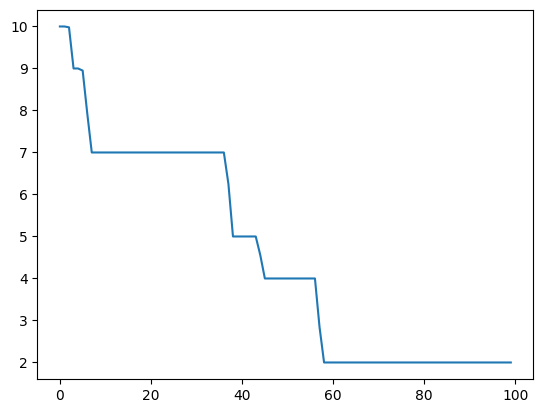

In [8]:
plt.plot(sol.ys)